In [ ]:
!pip install kaggle
!pip install rembg
!pip install onnxruntime
!pip install transformers accelerate torch torchvision pillow matplotlib evaluate

In [22]:
import os
import json
import pandas as pd
import numpy as np
import cv2
import skimage.io as io
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from pycocotools.coco import COCO
from PIL import Image
from pprint import pprint

# PyTorch & Albumentations (data augmentation)
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Hugging Face Transformers & Evaluate
from transformers import (
    Mask2FormerForUniversalSegmentation,
    Mask2FormerImageProcessor
)
import evaluate
from tqdm.auto import tqdm
from rembg import remove
import random
import kagglehub
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation




random.seed(42)

In [23]:
# Download latest version
path = kagglehub.dataset_download("wildlifedatasets/seaturtleid2022")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'seaturtleid2022' dataset.
Path to dataset files: /kaggle/input/seaturtleid2022


In [24]:
splits_csv_path = os.path.join(path, "turtles-data", "data", "metadata_splits.csv")

# Load the split file into a DataFrame
df = pd.read_csv(splits_csv_path)
df.head()

,id,width,height,file_name,timestamp,identity,date,year,split_closed,split_closed_random,split_open,clarity
0,1,2000,1333,images/t001/CAluWEgwPX.JPG,2014-07-14 14:49:45,t001,2014-07-14,2014,test,test,train,3
1,2,2000,1333,images/t001/EKyrFKHQzh.JPG,2014-07-14 14:48:49,t001,2014-07-14,2014,test,train,train,2
2,3,2000,1333,images/t001/ELAvEqeXxT.JPG,2014-07-14 14:49:48,t001,2014-07-14,2014,test,train,train,2
3,4,2000,1124,images/t001/IxRLFwTGCv.JPG,2010-07-02 14:09:40,t001,2010-07-02,2010,train,test,train,3
4,5,2000,1333,images/t001/LKCJAhfLBJ.JPG,2014-07-14 14:48:28,t001,2014-07-14,2014,test,test,train,4


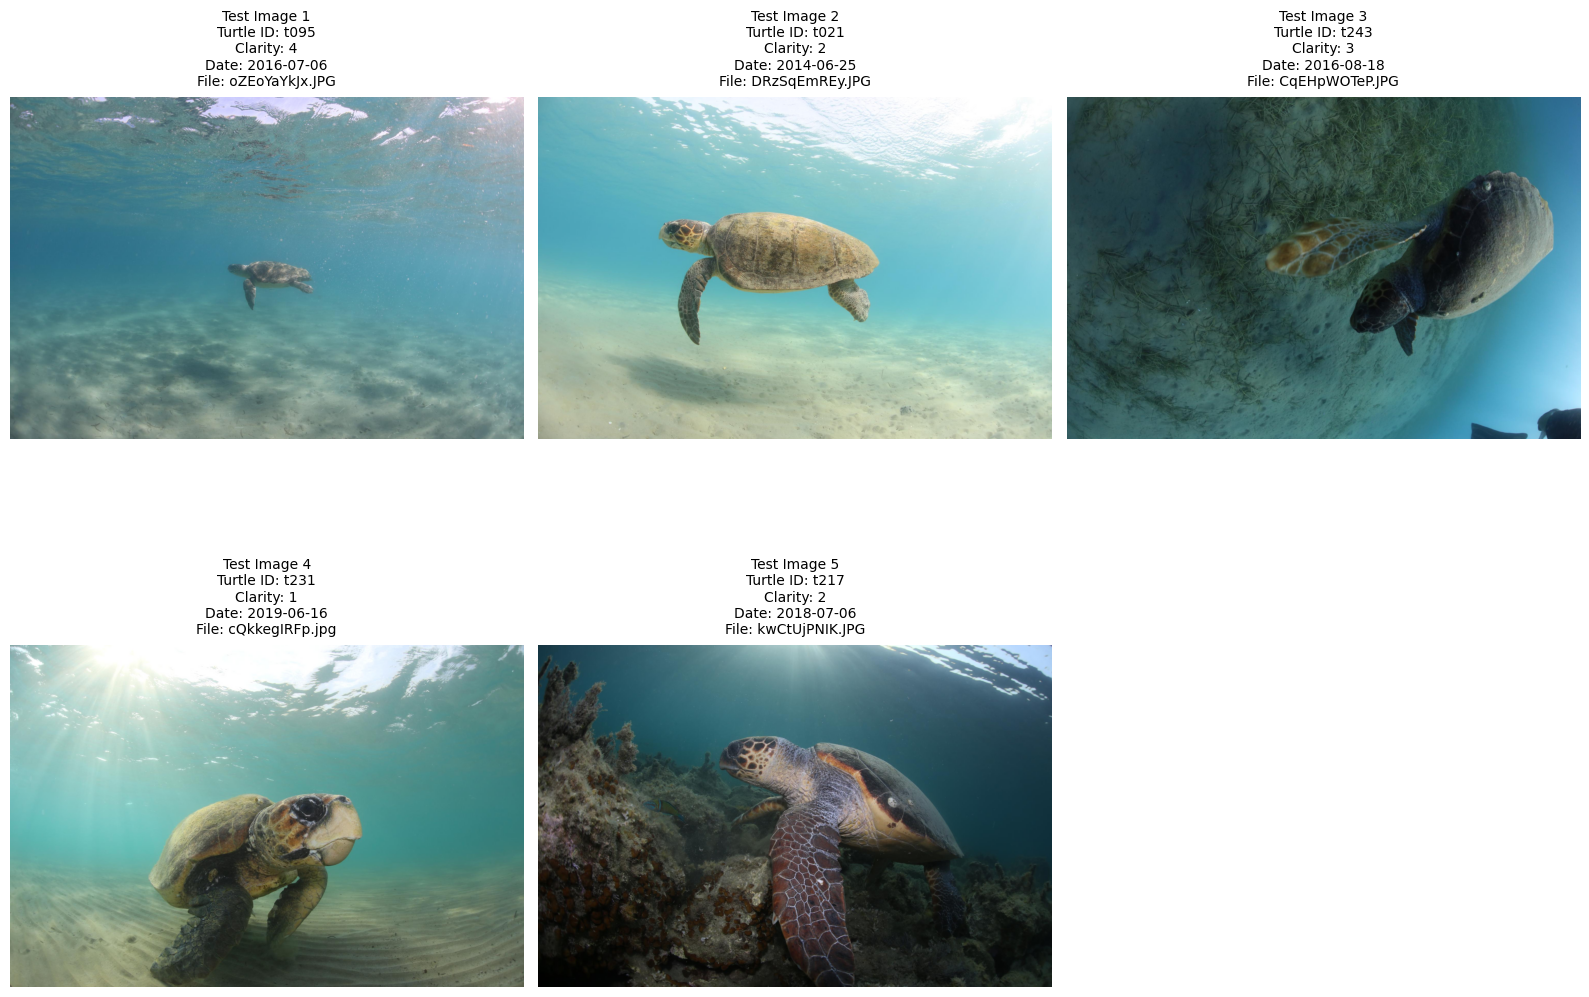

In [25]:
sample_test_rows = random.sample(list(df.iterrows()), 5)  # 5 random test rows
plt.figure(figsize=(16, 12))  # Adjust figure size for clarity

for i, (idx, row) in enumerate(sample_test_rows, 1):
    # Get full image path using the "file_name" column (relative → absolute path)
    full_image_path = os.path.join(path, "turtles-data", "data", row["file_name"])

    try:
        # Load image (convert to RGB to handle any transparency)
        image = Image.open(full_image_path).convert("RGB")

        # Create subplot
        plt.subplot(2, 3, i)
        plt.imshow(image)
        plt.axis("off")  # Hide axes

        # Add title with key info from your DataFrame
        title = (
            f"Test Image {i}\n"
            f"Turtle ID: {row['identity']}\n"
            f"Clarity: {row['clarity']}\n"
            f"Date: {row['date']}\n"
            f"File: {os.path.basename(row['file_name'])}"
        )
        plt.title(title, fontsize=10, wrap=True, pad=10)  # Wrap text to fit

    except Exception as e:
        # Handle missing/corrupted images gracefully
        plt.subplot(2, 3, i)
        plt.text(0.5, 0.5, f"Load Error:\n{str(e)[:25]}...",
                 ha="center", va="center", fontsize=9, color="red")
        plt.axis("off")

plt.tight_layout()  # Fix spacing between subplots
plt.show()

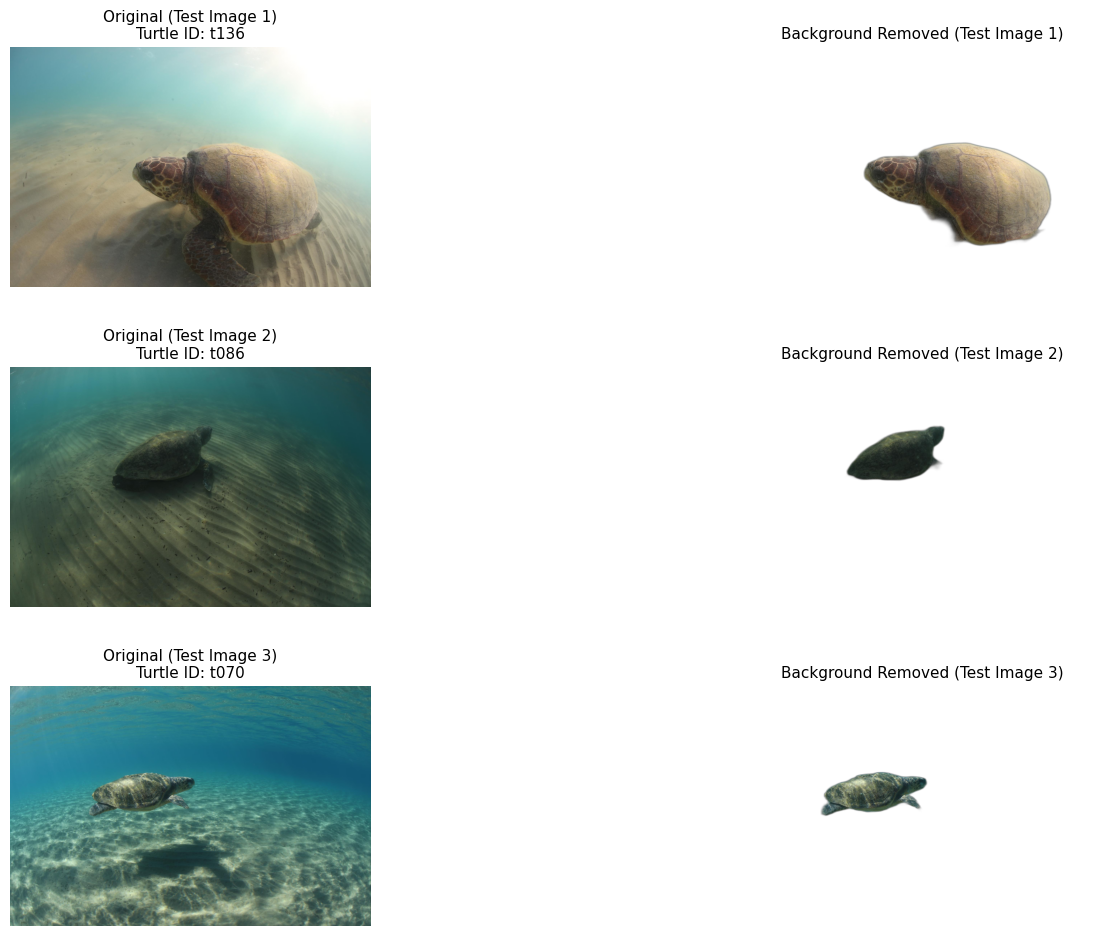

In [26]:
sample_rows = random.sample(list(df.iterrows()), 3)
plt.figure(figsize=(18, 10))  # Overall figure size

for i, (idx, row) in enumerate(sample_rows, 1):
    # Get full path to the original image (from your "file_name" column)
    original_img_path = os.path.join(path, "turtles-data", "data", row["file_name"])

    try:
        # Load original image
        original_img = Image.open(original_img_path).convert("RGB")

        # Step 1: Display original image (left column)
        plt.subplot(3, 2, 2*i - 1)  # 3 rows × 2 columns (left = original)
        plt.imshow(original_img)
        plt.axis("off")
        plt.title(f"Original (Test Image {i})\nTurtle ID: {row['identity']}", fontsize=11)

        # Step 2: Remove background (returns image with transparent background)
        # `remove()` auto detects foreground (turtle) and erases background
        bg_removed_img = remove(original_img)

        # Step 3: Display background-removed image (right column)
        plt.subplot(3, 2, 2*i)  # Right = background-removed
        plt.imshow(bg_removed_img)
        plt.axis("off")
        plt.title(f"Background Removed (Test Image {i})", fontsize=11)

    except Exception as e:
        # Handle errors (e.g., missing files, corrupted images)
        plt.subplot(3, 2, 2*i - 1)
        plt.text(0.5, 0.5, f"Error Loading Original:\n{str(e)[:25]}...",
                 ha="center", va="center", color="red")
        plt.axis("off")

        plt.subplot(3, 2, 2*i)
        plt.text(0.5, 0.5, "No Processed Image", ha="center", va="center", color="red")
        plt.axis("off")

plt.tight_layout(pad=3.0)  # Add spacing between subplots
plt.show()

In [27]:
annotations_path = os.path.join(path, "turtles-data", "data", "annotations.json")

with open(annotations_path, "r") as f:
    coco = json.load(f)

print("Images:", len(coco["images"]))
print("Annotations:", len(coco["annotations"]))
print("Categories:", coco["categories"])

Images: 8729
Annotations: 38414
Categories: [{'id': 1, 'name': 'turtle', 'supercategory': ''}, {'id': 2, 'name': 'flipper', 'supercategory': ''}, {'id': 3, 'name': 'head', 'supercategory': ''}]


loading annotations into memory...
Done (t=6.58s)
creating index...
index created!
Categories: ['turtle', 'flipper', 'head']


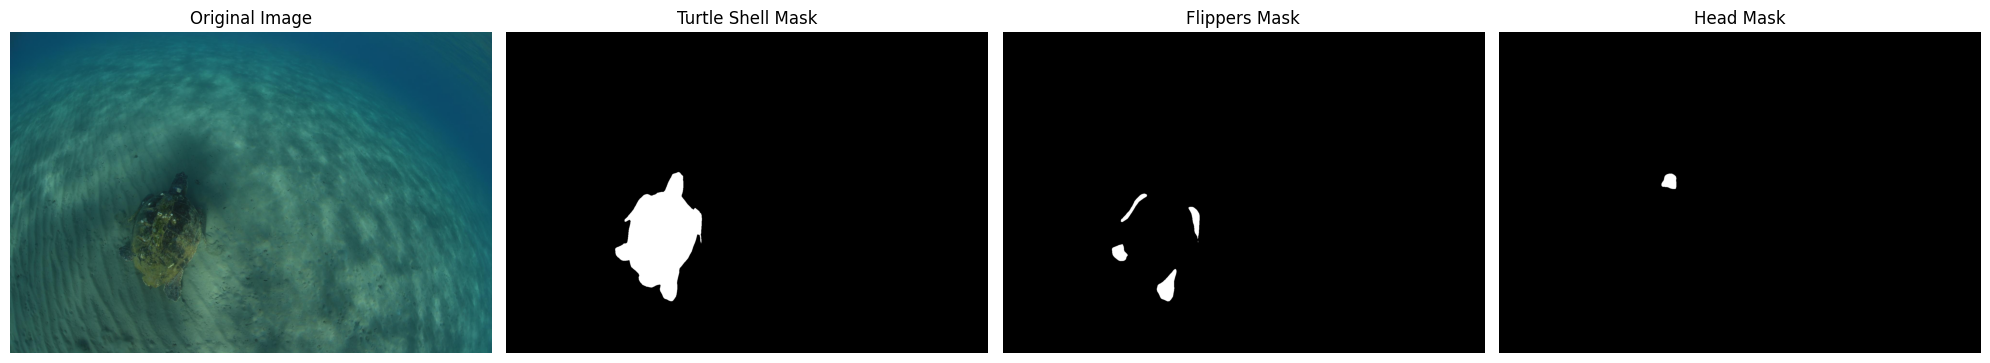

In [28]:
# Load COCO-style API for convenience
coco = COCO(annotations_path)

# Get category IDs
cat_ids = coco.getCatIds()
cats = coco.loadCats(cat_ids)
print("Categories:", [c["name"] for c in cats])

# Randomly choose one image
img_id = random.choice(coco.getImgIds())
img_info = coco.loadImgs(img_id)[0]
img_path = os.path.join(path, "turtles-data", "data", img_info["file_name"])

# Load image
image = np.array(Image.open(img_path).convert("RGB"))

# Get all annotations for this image
ann_ids = coco.getAnnIds(imgIds=[img_id])
anns = coco.loadAnns(ann_ids)

# Prepare blank masks for each category
height, width = image.shape[:2]
mask_dict = {"turtle": np.zeros((height, width), dtype=np.uint8),
             "flipper": np.zeros((height, width), dtype=np.uint8),
             "head": np.zeros((height, width), dtype=np.uint8)}

# Build masks by category
for ann in anns:
    cat_id = ann["category_id"]
    cat_name = coco.loadCats(cat_id)[0]["name"]
    mask = coco.annToMask(ann)
    if cat_name in mask_dict:
        mask_dict[cat_name] = np.maximum(mask_dict[cat_name], mask)  # combine overlapping masks

# 🧩 Visualization
fig, axs = plt.subplots(1, 4, figsize=(20, 6))

axs[0].imshow(image)
axs[0].set_title("Original Image")
axs[0].axis("off")

axs[1].imshow(mask_dict["turtle"], cmap="gray")
axs[1].set_title("Turtle Shell Mask")
axs[1].axis("off")

axs[2].imshow(mask_dict["flipper"], cmap="gray")
axs[2].set_title("Flippers Mask")
axs[2].axis("off")

axs[3].imshow(mask_dict["head"], cmap="gray")
axs[3].set_title("Head Mask")
axs[3].axis("off")

plt.tight_layout()
plt.show()

In [29]:
split = 'split_open'
train_image_ids = []
val_image_ids = []
test_image_ids = []

for _, row in df.iterrows():
    if row[split] == 'train':
        train_image_ids.append(row['id'])
    elif row[split] == 'valid':
        val_image_ids.append(row['id'])
    else:
        test_image_ids.append(row['id'])

print('Train set length:', len(train_image_ids))
print('Validation set length:', len(val_image_ids))
print('Test set length:', len(test_image_ids))

Train set length: 5303
Validation set length: 1118
Test set length: 2308


In [43]:
df = pd.read_csv(splits_csv_path)
coco = COCO(annotations_path)
data_root = os.path.join(path, "turtles-data", "data")
IMG_SIZE = (256, 256)
BATCH_SIZE = 2
ALL_CLASSES = ['background', 'turtle', 'flipper', 'head']
NO_CLASSES = 4
COLOUR_CODING = np.array([
    [0, 0, 0],      # background -> black
    [255, 0, 0],    # turtle -> red
    [0, 255, 0],    # flipper -> green
    [0, 0, 255]     # head -> blue
])

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")


loading annotations into memory...
Done (t=5.50s)
creating index...
index created!
Using device: cpu


In [44]:
train_image_ids = df[df['split_open'] == 'train']['id'].tolist()
val_image_ids = df[df['split_open'] == 'valid']['id'].tolist()
test_image_ids = df[df['split_open'] == 'test']['id'].tolist()
print(f"\nData split:")
print(f"Train set: {len(train_image_ids)} images")
print(f"Val set: {len(val_image_ids)} images")
print(f"Test set: {len(test_image_ids)} images")


Data split:
Train set: 5303 images
Val set: 1118 images
Test set: 2308 images


In [45]:
def get_transforms(mode):
    if mode == "train":
        return A.Compose([
            A.Resize(height=IMG_SIZE[0], width=IMG_SIZE[1], always_apply=True),
            A.HorizontalFlip(p=0.4),
            A.RandomBrightnessContrast(p=0.15),
            A.Rotate(limit=20),
            ToTensorV2()  # Convert to PyTorch tensor (C, H, W)
        ], additional_targets={'mask': 'mask'})
    else:  # val/test
        return A.Compose([
            A.Resize(height=IMG_SIZE[0], width=IMG_SIZE[1], always_apply=True),
            ToTensorV2()
        ], additional_targets={'mask': 'mask'})

# Helper function to generate segmentation mask (original logic)
def get_image_mask(image_id, coco):
    cat_ids = coco.getCatIds()
    ann_ids = coco.getAnnIds(imgIds=image_id, catIds=cat_ids, iscrowd=None)
    anns = coco.loadAnns(ann_ids)
    # Initialize mask with image height/width
    img_info = coco.imgs[image_id]
    mask = np.zeros((img_info['height'], img_info['width']), dtype=int)
    for ann in anns:
        submask = coco.annToMask(ann)  # Get single annotation mask
        mask = np.maximum(mask, submask * ann['category_id'])  # Merge masks
    return mask

In [46]:
class SeaTurtleDataset(Dataset):
    def __init__(self, image_ids, coco, transform, prefix_dir):
        self.image_ids = image_ids
        self.coco = coco
        self.transform = transform
        self.prefix_dir = prefix_dir

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, index):
        # 1. Load image
        img_id = self.image_ids[index]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.prefix_dir, img_info['file_name'])
        img = io.imread(img_path)  # Shape: (H, W, 3)
        if len(img.shape) == 2:  # Handle grayscale images (if any)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        # 2. Load segmentation mask
        mask = get_image_mask(img_id, self.coco)  # Shape: (H, W)

        # 3. Apply transformations
        transformed = self.transform(image=img, mask=mask)
        img_tensor = transformed['image']  # Shape: (3, 256, 256)
        mask_tensor = transformed['mask'].long()  # Shape: (256, 256) (int64 for labels)

        return {
            "image": img_tensor,
            "mask": mask_tensor,
            "image_id": img_id
        }

In [47]:
train_transform = get_transforms("train")
val_transform = get_transforms("val")

train_dataset = SeaTurtleDataset(
    image_ids=train_image_ids,
    coco=coco,
    transform=train_transform,
    prefix_dir=data_root
)
val_dataset = SeaTurtleDataset(
    image_ids=val_image_ids,
    coco=coco,
    transform=val_transform,
    prefix_dir=data_root
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2  # Adjust based on your CPU cores
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

/tmp/ipython-input-2177857688.py:4: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  A.Resize(height=IMG_SIZE[0], width=IMG_SIZE[1], always_apply=True),
/tmp/ipython-input-2177857688.py:12: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  A.Resize(height=IMG_SIZE[0], width=IMG_SIZE[1], always_apply=True),


In [48]:
def load_model(num_classes=4):
    image_processor = Mask2FormerImageProcessor(
        ignore_index=255, reduce_labels=False
    )
    model = Mask2FormerForUniversalSegmentation.from_pretrained(
        'facebook/mask2former-swin-tiny-ade-semantic',
        num_labels=num_classes,
        ignore_mismatched_sizes=True
    )
    return model, image_processor

model, processor = load_model()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/tmp/ipython-input-1013111127.py:2: UserWarning: The following named arguments are not valid for `Mask2FormerImageProcessor.__init__` and were ignored: 'reduce_labels'
  image_processor = Mask2FormerImageProcessor(
Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-tiny-ade-semantic and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([5]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Mask2FormerForUniversalSegmentation(
  (model): Mask2FormerModel(
    (pixel_level_module): Mask2FormerPixelLevelModule(
      (encoder): SwinBackbone(
        (embeddings): SwinEmbeddings(
          (patch_embeddings): SwinPatchEmbeddings(
            (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
          )
          (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (encoder): SwinEncoder(
          (layers): ModuleList(
            (0): SwinStage(
              (blocks): ModuleList(
                (0): SwinLayer(
                  (layernorm_before): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
                  (attention): SwinAttention(
                    (self): SwinSelfAttention(
                      (query): Linear(in_features=96, out_features=96, bias=True)
                      (key): Linear(in_features=96, out_features=96, bias=True)
                      (value): Lin

In [49]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
metric = evaluate.load("mean_iou")

EPOCHS = 5
best_val_loss = float("inf")
best_val_iou = 0.0

In [ ]:
for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    model.train()
    train_loss = 0.0

    for batch in tqdm(train_loader, desc="Training"):
        images = batch["image"].to(device)
        masks = batch["mask"].to(device)

        inputs = processor(images=list(images), segmentation_maps=list(masks), return_tensors="pt").to(device)
        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        del inputs, outputs
        gc.collect()
        torch.cuda.empty_cache()

    avg_train_loss = train_loss / len(train_loader)
    print(f"Train Loss: {avg_train_loss:.4f}")

    # ==========================
    # Validation
    # ==========================
    model.eval()
    val_loss = 0.0
    metric.reset()

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating"):
            images = batch["image"].to(device)
            masks = batch["mask"].to(device)
            inputs = processor(images=list(images), return_tensors="pt").to(device)
            outputs = model(**inputs)
            loss = outputs.loss
            val_loss += loss.item()

            target_sizes = [(m.shape[0], m.shape[1]) for m in masks]
            preds = processor.post_process_semantic_segmentation(outputs, target_sizes=target_sizes)
            metric.add_batch(predictions=preds, references=[m.cpu().numpy() for m in masks])

            del inputs, outputs
            gc.collect()
            torch.cuda.empty_cache()

    results = metric.compute(num_labels=4, ignore_index=255, reduce_labels=False)
    avg_val_loss = val_loss / len(val_loader)
    mean_iou = results["mean_iou"]

    print(f"Val Loss: {avg_val_loss:.4f} | mIoU: {mean_iou:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_model_loss.pth")
        print("✅ Saved model (best validation loss).")

    if mean_iou > best_val_iou:
        best_val_iou = mean_iou
        torch.save(model.state_dict(), "best_model_iou.pth")
        print("✅ Saved model (best mIoU).")



Epoch 1/5


Training:   0%|          | 0/2652 [00:00<?, ?it/s]

In [ ]:
model.eval()
test_img = io.imread(os.path.join(data_root, coco.loadImgs(val_image_ids[0])[0]['file_name']))
inputs = processor(images=test_img, return_tensors="pt").to(device)
outputs = model(**inputs)
pred = processor.post_process_semantic_segmentation(outputs, target_sizes=[test_img.shape[:2]])[0]

plt.imshow(pred.cpu().numpy())
plt.title("Predicted Segmentation")
plt.axis("off")
plt.show()